## Example usage of Tempestpy

In [1]:
#!/usr/bin/env python
# coding: utf-8

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat
import gymnasium as gym
from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper
import tempfile, datetime, shutil
import time
import os
from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, ImageRecorderCallback, InfoCallback
# from utils import PerceptionLossShieldHandler  # New import
import os, sys
from copy import deepcopy
from PIL import Image

pygame 2.6.1 (SDL 2.28.4, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-11-18 15:01:45.712993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 15:01:45.721405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731942105.731486  230821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731942105.734627  230821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:01:45.746118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Starting the training


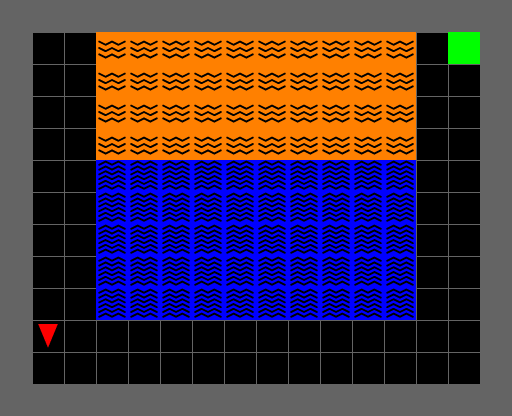

Entered into Modified Wrapper
Initialized Simulator


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.03976035118103027 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0005209445953369141 seconds.
LOG: Starting to translate shield...
Write to file shielding_files_20241118T150147_i2_6r3zu/shield.
Elapsed time is 0.0107879638671875 seconds.
Entered into Modified Wrapper
Initialized Simulator


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.04120755195617676 seconds.
LOG: Starting with model checking...
Elapsed time is 0.0005335807800292969 seconds.
LOG: Starting to translate shield...
Write to file shielding_files_20241118T150147_d88o47r0/shield.
Elapsed time is 0.009963512420654297 seconds.
Entered into Modified Wrapper
Initialized Simulator


Computing new shield
LOG: Starting with explicit model creation...
Elapsed time is 0.04140973091125488 seconds.
LOG: Starting with model checking...
Elapsed

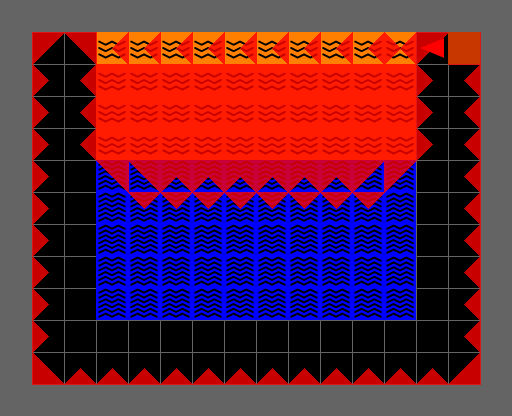

The shield for shield_value = 0.9


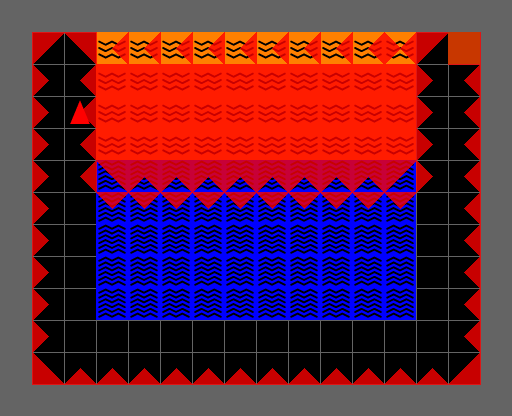

The shield for shield_value = 0.95


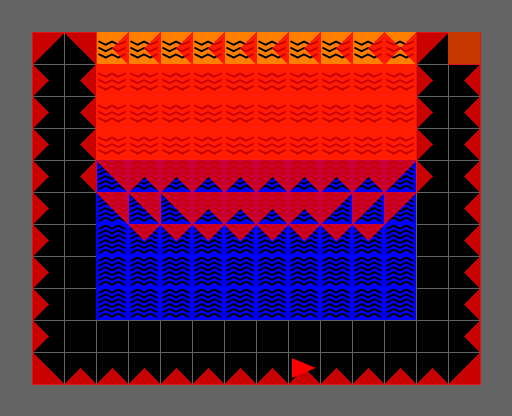

The shield for shield_value = 0.99


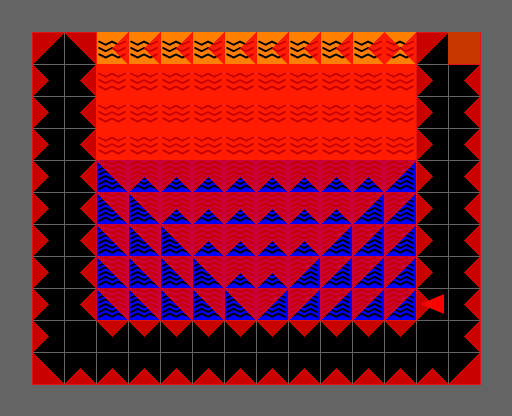

The shield for shield_value = 1.0
Entered into Modified Wrapper
Initialized Simulator
Training with shield:


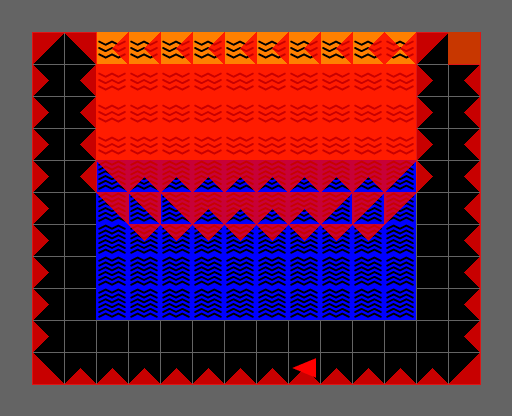

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
create_action_mask() --- 1
Inside get_sheild_actions() calculating safe actions
Stats of simulator {'window_size': 0, 'blanked_count': 0, 'window_state': [], 'total_steps': 0}
Moving to next step in simulator
Old Shield's Action-------->
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
New Shield's Safe actions -------->
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
create_action_mask() --- 1
Inside get_sheild_actions() calculating safe actions
Stats of simulator {'window_size': 1, 'blanked_count': 0, 'window_state': [False], 'total_steps': 1}
Moving to next step in simulator
Agent blanked out at 2
Finding possible states
symbolically simulated new state State(colAgent=np.int64(1), rowAgent=np.int64(7), viewAgent=1, carrying='', adversaries=(), balls=(), boxes=(), keys=(), doors=(), lockeddoors=())
symbolically simulated new state State(colAgent=np.int64(1), rowAgent=np.int64

SystemExit: No safe actions possible, shield stopped.

In [2]:
os.environ['M2P_BINARY'] = '/opt/Minigrid2PRISM/build/main'
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")

def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7

def main():
    env = "MiniGrid-LavaSlipperyCliff-16x13-Slip10-Time-v0"
    
    formula = "Pmax=? [G ! AgentIsOnLava]"
    value_for_training = 0.99
    shield_comparison =  "absolute"
    shielding = ShieldingConfig.Training
    
    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])
    
    env = gym.make(env, render_mode="rgb_array")
    image_env = RGBImgObsWrapper(env, TILE_PIXELS)
    env = RGBImgObsWrapper(env, 8)
    env = ImgObsWrapper(env)
    env = MiniWrapper(env)

    
    env.reset()
    Image.fromarray(env.render()).show()
    
    shield_handlers = dict()
    if shield_needed(shielding):
        for value in [0.9, 0.95, 0.99, 1.0]:
            shield_handler = MiniGridShieldHandler(GRID_TO_PRISM_BINARY, "grid.txt", "grid.prism", formula, shield_value=value, shield_comparison=shield_comparison, nocleanup=True, prism_file=None)
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False ,k=3 , n=10)


            shield_handlers[value] = shield_handler
    if shield_needed(shielding):
        for value in [0.9, 0.95, 0.99, 1.0]:            
            create_shield_overlay_image(image_env, shield_handlers[value].create_shield())
            print(f"The shield for shield_value = {value}")

    if shielding == ShieldingConfig.Training:
        env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handlers[value_for_training], create_shield_at_reset=False,k=3,n=10)
        env = ActionMasker(env, mask_fn)
        print("Training with shield:")
        create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
    elif shielding == ShieldingConfig.Disabled:
        env = ActionMasker(env, nomask_fn)
    else:
        assert(False) 
    model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
    model.set_logger(logger)
    steps = 20_000

    # assert(False)
    model.learn(steps,callback=[InfoCallback()])



if __name__ == '__main__':
    print("Starting the training")
    main()